In [15]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
def fetch_energy_data(start_date: datetime.date, end_date:datetime.date):
    """
    Fetches the energy data from the API for the given date range.
    Args:
        start_date: The start date of the date range.
        end_date: The end date of the date range.

    Returns:
        A pandas dataframe containing the energy data.
    """
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.energidataservice.dk/dataset/DeclarationProduction?start={start_date}&end={end_date}&filter=%7B%22PriceArea%22%3A%5B%22DK1%22%5D%7D"
    response = requests.get(url)
    data = response.json()

    # Process and structure the data
    if data['records']:
        df = pd.DataFrame(data['records'])
        df = df[df['ProductionType'] == 'Solar']
        df = df[['HourDK', 'Production_MWh']]
        df = df.groupby('HourDK').sum().reset_index()
        return df
    else:
        print("No data available for the given date range.")
        return None

In [3]:
# Define the date range for which the data is to be fetched
start_date = datetime.now() - timedelta(days=100)
end_date = datetime.now() - timedelta(days=14)

# Fetch the energy data
energy_data = fetch_energy_data(start_date, end_date)

In [4]:
energy_data.head()

,HourDK,Production_MWh
0,2024-07-18T00:00:00,0.546547
1,2024-07-18T01:00:00,0.481421
2,2024-07-18T02:00:00,0.402701
3,2024-07-18T03:00:00,0.424766
4,2024-07-18T04:00:00,0.444060


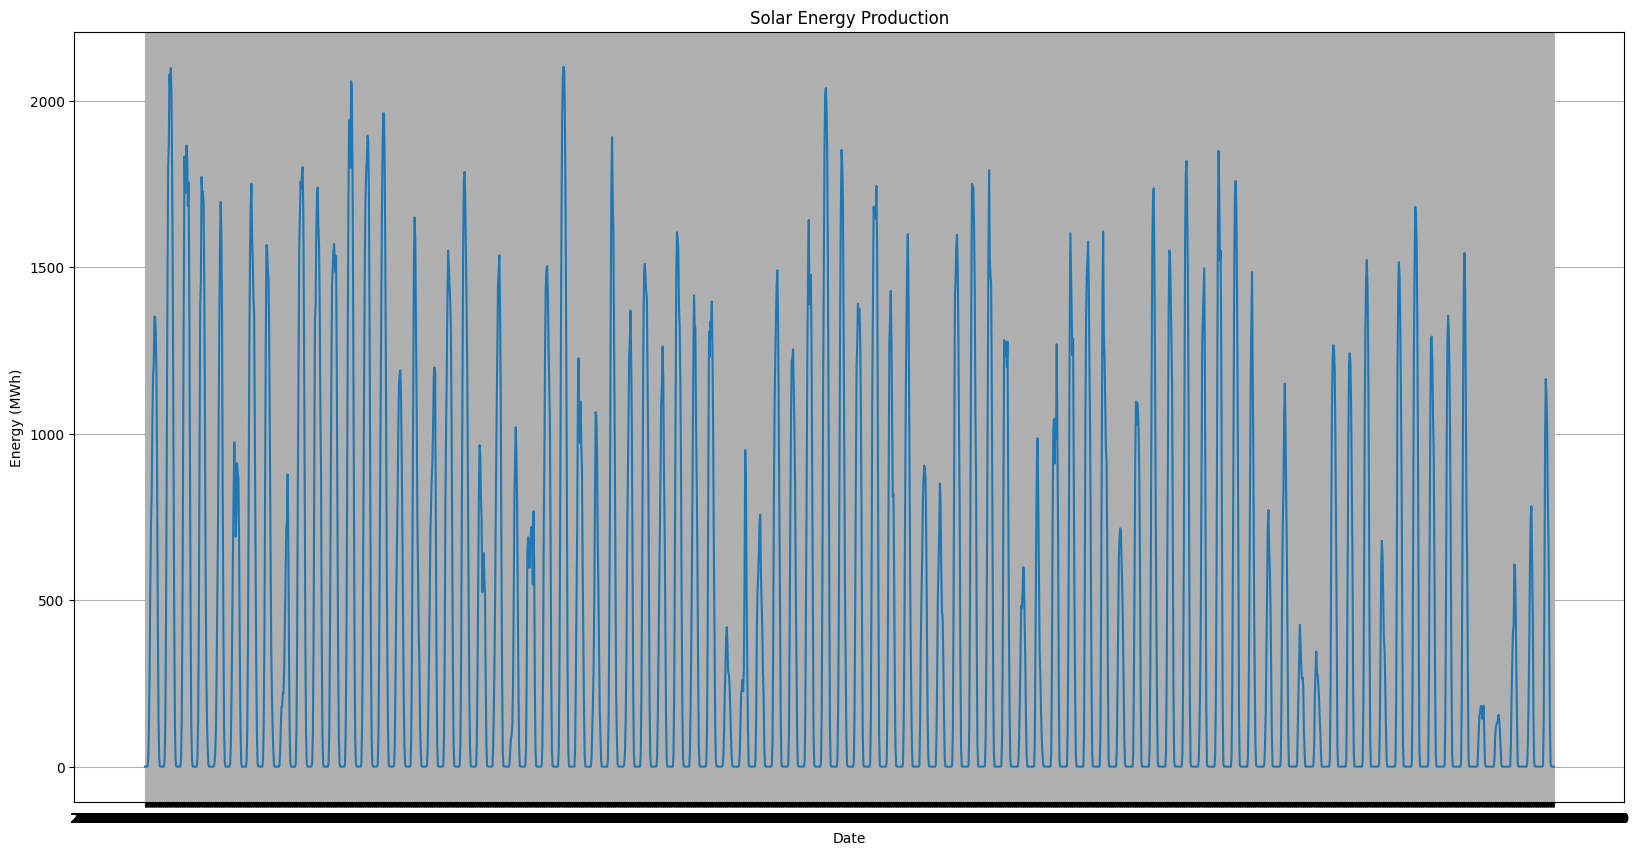

In [5]:
# Plot the energy data
plt.figure(figsize=(20, 10))
plt.plot(energy_data['HourDK'], energy_data['Production_MWh'])
plt.xlabel('Date')
plt.ylabel('Energy (MWh)')
plt.title('Solar Energy Production')
plt.grid()
plt.show()

### LTSM model

In [6]:
df = energy_data

In [7]:
# Preprocess data
scaler = MinMaxScaler()
df['Production_MWh'] = scaler.fit_transform(df[['Production_MWh']])

# Define parameters
sequence_length = 72  # input sequence length (e.g., last 72 hours)
prediction_horizon = 24  # we want to predict the next 24 hours
X, y = [], []

# Create sequences
for i in range(sequence_length, len(df) - prediction_horizon):
    X.append(df['Production_MWh'].values[i-sequence_length:i])
    y.append(df['Production_MWh'].values[i:i+prediction_horizon])

X, y = np.array(X), np.array(y)

# Reshape X to be suitable for LSTM: (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1)),
    Dense(32, activation='relu'),
    Dense(prediction_horizon)  # output the 24 hours prediction
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# Predicting the next 24 hours at each step
def predict_next_24_hours(data, model, scaler, sequence_length=sequence_length):
    """
    Predict the next 24 hours based on the most recent `sequence_length` hours.
    """
    # Select the most recent sequence
    last_sequence = data['Production_MWh'].values[-sequence_length:]
    last_sequence = scaler.transform(last_sequence.reshape(-1, 1))
    last_sequence = last_sequence.reshape((1, sequence_length, 1))

    # Predict the next 24 hours
    prediction = model.predict(last_sequence)
    prediction = scaler.inverse_transform(prediction)  # Inverse scale
    return prediction.flatten()

/Users/idlirshkurti/Library/Caches/pypoetry/virtualenvs/energy-forecast-Dv7C83G4-py3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,768 (77.22 KB)

 Trainable params: 19,768 (77.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1086 - val_loss: 0.0431
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0670 - val_loss: 0.0322
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0342 - val_loss: 0.0247
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0215 - val_loss: 0.0289
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0193 - val_loss: 0.0236
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - val_loss: 0.0210
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - val_loss: 0.0215
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - val_loss: 0.0184
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - val_loss: 0.0190
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0175
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - val_loss: 0.0210
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 - val_lo

## Evaluation

In [8]:
# Convert 'HourDK' to datetime and set as index
energy_data['HourDK'] = pd.to_datetime(energy_data['HourDK'])
energy_data.set_index('HourDK', inplace=True)

# Scale 'Production_MWh' for model input
scaler = MinMaxScaler()
energy_data['Scaled_Production'] = scaler.fit_transform(energy_data[['Production_MWh']])

# Define parameters
sequence_length = 72  # Number of past hours used for each forecast
forecast_horizon = 24  # Forecasting the next 24 hours

# Prepare to store results
predictions = []
actuals = []

# Generate rolling forecasts
for start in range(len(energy_data) - sequence_length - forecast_horizon):
    # Get past `sequence_length` hours as input for the model
    input_sequence = energy_data['Scaled_Production'].values[start : start + sequence_length]
    input_sequence = input_sequence.reshape((1, sequence_length, 1))

    # Predict the next 24 hours (in scaled form)
    scaled_forecast = model.predict(input_sequence)

    # Inverse-transform to original scale
    forecast = scaler.inverse_transform(scaled_forecast).flatten()

    # Clip negative forecasted values to zero
    forecast = np.clip(forecast, 0, None)

    # Store forecast and actual values for evaluation
    predictions.extend(forecast)
    actual_values = energy_data['Production_MWh'].values[start + sequence_length : start + sequence_length + forecast_horizon]
    actuals.extend(actual_values)

# Calculate evaluation metrics on the original scale
rmse = mean_squared_error(actuals, predictions, squared=False)
mae = mean_absolute_error(actuals, predictions)

print(f"24-hour Rolling Forecast RMSE: {rmse}")
print(f"24-hour Rolling Forecast MAE: {mae}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/Users/idlirshkurti/Library/Caches/pypoetry/virtualenvs/energy-forecast-Dv7C83G4-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/var/folders/k1/2hxgqw8d22x59b6kv7st7w000000gn/T/ipykernel_40599/1579714707.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(energy_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_horizon, freq='H')


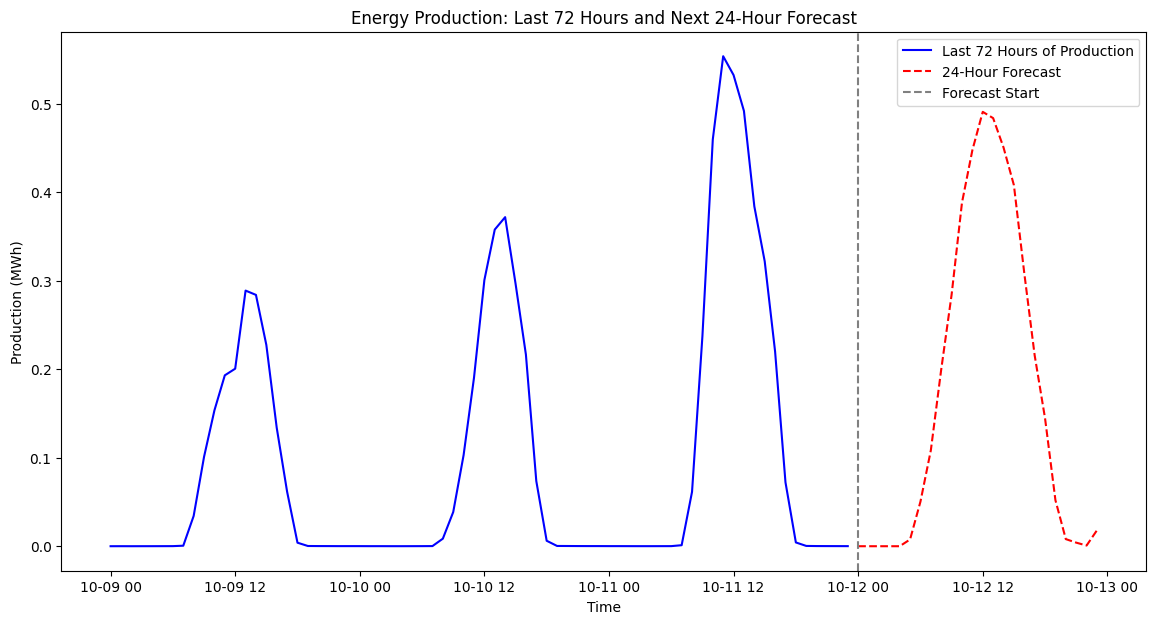

In [9]:
# Scale 'Production_MWh' for model input
scaler = MinMaxScaler()
energy_data['Scaled_Production'] = scaler.fit_transform(energy_data[['Production_MWh']])

# Define sequence length and forecast horizon
sequence_length = 72
forecast_horizon = 24

# Get the last `sequence_length` hours as input for the model
last_sequence = energy_data['Scaled_Production'].values[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))

# Predict the next 24 hours in scaled form
scaled_forecast = model.predict(last_sequence)

# Inverse-transform to original scale
forecast = scaler.inverse_transform(scaled_forecast).flatten()

# Clip negative forecasted values to zero
forecast = np.clip(forecast, 0, None)

# Create a DataFrame for the forecast
forecast_index = pd.date_range(energy_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_horizon, freq='H')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecasted_Production_MWh'])

# Plot the last 72 hours of historical data and the 24-hour forecast
plt.figure(figsize=(14, 7))

# Plot the last 72 hours of historical data
plt.plot(energy_data.index[-sequence_length:], energy_data['Production_MWh'].values[-sequence_length:], label='Last 72 Hours of Production', color='blue')

# Plot the 24-hour forecast
plt.plot(forecast_df.index, forecast_df['Forecasted_Production_MWh'], label='24-Hour Forecast', color='red', linestyle='--')

# Add a vertical line to mark the beginning of the forecast
plt.axvline(x=forecast_df.index[0], color='gray', linestyle='--', label='Forecast Start')

# Label the plot
plt.xlabel('Time')
plt.ylabel('Production (MWh)')
plt.title('Energy Production: Last 72 Hours and Next 24-Hour Forecast')
plt.legend()
plt.show()

In [10]:
# Save the model to disk
model.save('../models/solar_energy_production_model.keras')

# Run forecast pipeline

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/var/folders/k1/2hxgqw8d22x59b6kv7st7w000000gn/T/ipykernel_40599/3646288869.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(df.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')


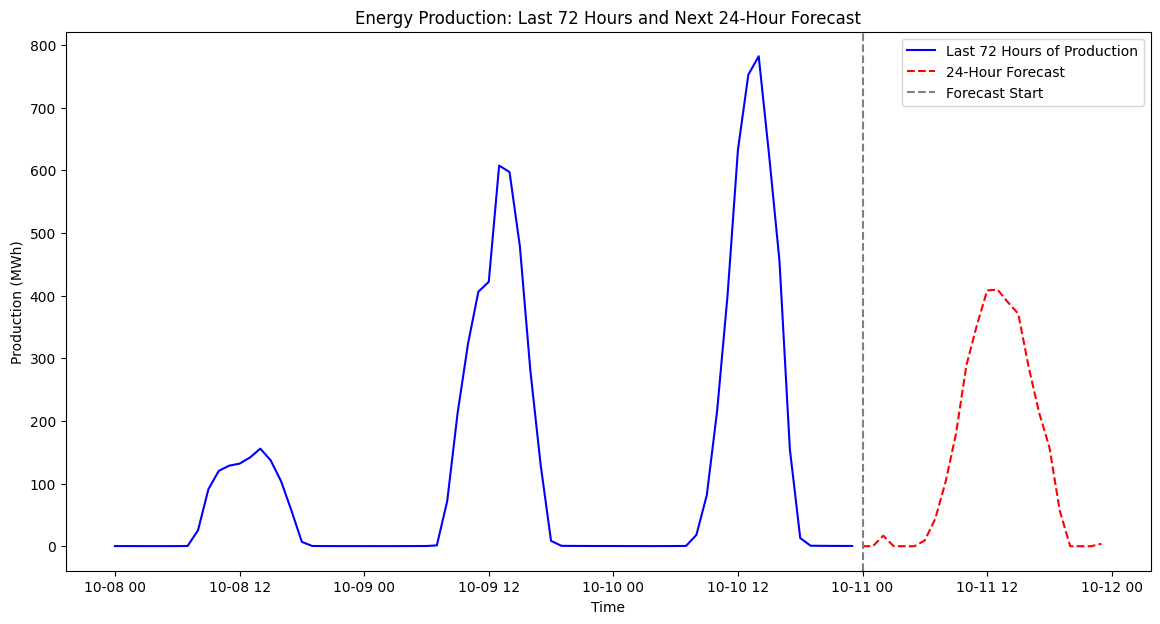

In [11]:
# Function to retrieve and preprocess the required historical data
def get_historical_data_for_forecast(end_date, sequence_length=72):
    """
    Retrieves and preprocesses the historical data needed for a 24-hour forecast.
    """
    # Define the start date based on the sequence length required
    start_date = end_date - timedelta(hours=sequence_length)
    
    # Fetch data
    df = fetch_energy_data(start_date=start_date, end_date=end_date)
    
    if df is None or df.empty:
        raise ValueError("Insufficient data retrieved for the specified date range.")
    
    # Convert 'HourDK' to datetime and set as index
    df['HourDK'] = pd.to_datetime(df['HourDK'])
    df.set_index('HourDK', inplace=True)

    # Check if we have enough data points
    if len(df) < sequence_length:
        raise ValueError("Insufficient historical data to make the forecast.")
    
    return df

# Pipeline to make a forecast
def make_forecast_for_next_24_hours(model, end_date, sequence_length=72):
    """
    Retrieves data, preprocesses it, and makes a 24-hour forecast using the LSTM model.
    """
    # Get the historical data needed
    df = get_historical_data_for_forecast(end_date, sequence_length=sequence_length)
    
    # Scale the 'Production_MWh' column for model input
    scaler = MinMaxScaler()
    df['Scaled_Production'] = scaler.fit_transform(df[['Production_MWh']])
    
    # Prepare the input sequence for the LSTM model
    last_sequence = df['Scaled_Production'].values[-sequence_length:]
    last_sequence = last_sequence.reshape((1, sequence_length, 1))

    # Predict the next 24 hours
    scaled_forecast = model.predict(last_sequence)
    forecast = scaler.inverse_transform(scaled_forecast).flatten()

    # Clip negative forecasted values to zero
    forecast = np.clip(forecast, 0, None)

    # Create a DataFrame for the forecast
    forecast_index = pd.date_range(df.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecasted_Production_MWh'])

    # Plotting the historical data and forecast
    plt.figure(figsize=(14, 7))
    # Plot the last 72 hours of historical data
    plt.plot(df.index[-sequence_length:], df['Production_MWh'].values[-sequence_length:], label='Last 72 Hours of Production', color='blue')
    # Plot the forecast
    plt.plot(forecast_df.index, forecast_df['Forecasted_Production_MWh'], label='24-Hour Forecast', color='red', linestyle='--')
    # Add a dashed vertical line at the start of the forecast
    plt.axvline(x=forecast_df.index[0], color='gray', linestyle='--', label='Forecast Start')
    # Label the plot
    plt.xlabel('Time')
    plt.ylabel('Production (MWh)')
    plt.title('Energy Production: Last 72 Hours and Next 24-Hour Forecast')
    plt.legend()
    plt.show()
    
    return forecast_df

# Usage example
# Assuming `model` is the trained LSTM model
end_date = datetime.now() - timedelta(days=15)  # End date for the historical data retrieval
forecast_df = make_forecast_for_next_24_hours(model, end_date, sequence_length=72)


## Conformal predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

/var/folders/k1/2hxgqw8d22x59b6kv7st7w000000gn/T/ipykernel_40599/3525100309.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(historical_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_horizon, freq='H')


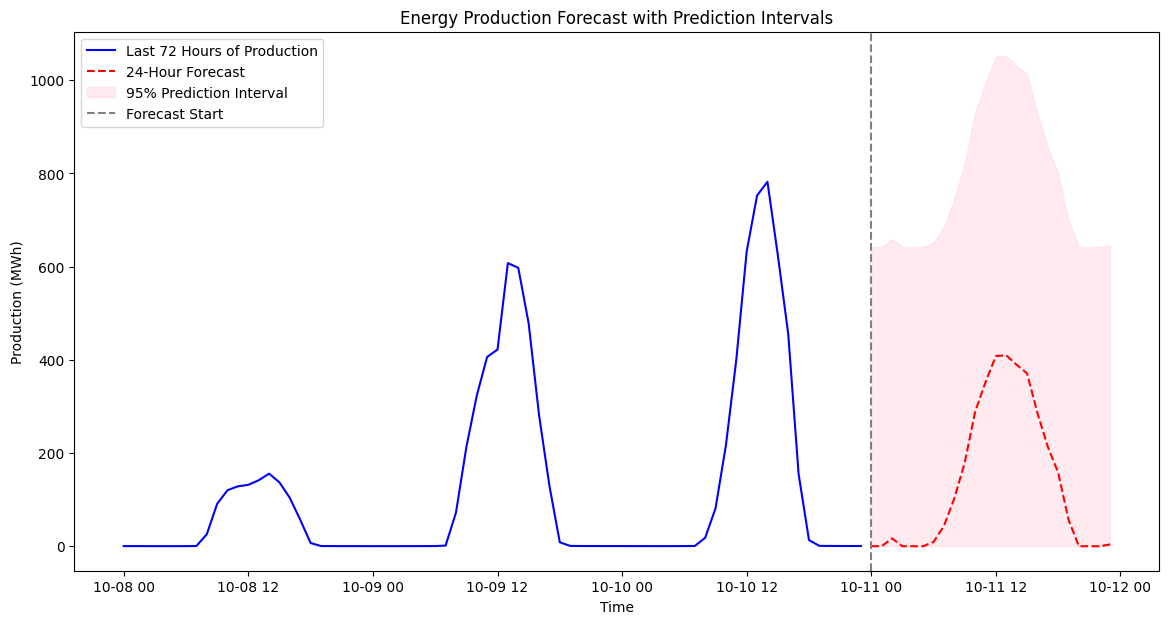

In [16]:
# Define quantile for the confidence interval (e.g., 95%)
confidence_level = 0.95
alpha = 1 - confidence_level  # This will yield a 95% prediction interval

# Step 1: Fetch historical data and preprocess as before
def get_calibration_data():
    """
    Fetches historical data for the calibration set and preprocesses it for conformal prediction.
    """
    # Define a calibration date range (e.g., last 2 weeks or month of data)
    end_date = datetime.now() - timedelta(days=15)
    start_date = end_date - timedelta(days=30)  # Adjust range as needed
    df = fetch_energy_data(start_date=start_date, end_date=end_date)

    if df is None or df.empty:
        raise ValueError("Insufficient calibration data retrieved for the specified date range.")

    # Convert 'HourDK' to datetime and set as index
    df['HourDK'] = pd.to_datetime(df['HourDK'])
    df.set_index('HourDK', inplace=True)

    return df

# Step 2: Generate calibration forecasts and calculate residuals
def calculate_residuals_for_conformal(model, calibration_data, sequence_length=72, forecast_horizon=24):
    """
    Calculate residuals for the calibration data to determine conformal prediction intervals.
    """
    scaler = MinMaxScaler()
    calibration_data['Scaled_Production'] = scaler.fit_transform(calibration_data[['Production_MWh']])

    residuals = []

    # Loop to make forecasts over calibration data and collect residuals
    for start in range(len(calibration_data) - sequence_length - forecast_horizon):
        # Prepare input sequence
        input_sequence = calibration_data['Scaled_Production'].values[start : start + sequence_length]
        input_sequence = input_sequence.reshape((1, sequence_length, 1))
        
        # Predict and inverse scale
        scaled_forecast = model.predict(input_sequence)
        forecast = scaler.inverse_transform(scaled_forecast).flatten()
        
        # Clip and get actual values
        forecast = np.clip(forecast, 0, None)
        actual_values = calibration_data['Production_MWh'].values[start + sequence_length : start + sequence_length + forecast_horizon]

        # Calculate residuals
        residuals.extend(np.abs(forecast - actual_values))

    return np.array(residuals)

# Step 3: Calculate conformal quantiles and apply to forecast
def make_conformal_forecast(model, end_date, residuals, sequence_length=72, forecast_horizon=24, alpha=0.05):
    """
    Make a forecast with conformal prediction intervals for the next 24 hours.
    """
    # Retrieve and preprocess historical data
    historical_data = get_historical_data_for_forecast(end_date, sequence_length=sequence_length)
    
    # Scale 'Production_MWh' for model input
    scaler = MinMaxScaler()
    historical_data['Scaled_Production'] = scaler.fit_transform(historical_data[['Production_MWh']])

    # Prepare input sequence for the model
    last_sequence = historical_data['Scaled_Production'].values[-sequence_length:]
    last_sequence = last_sequence.reshape((1, sequence_length, 1))

    # Predict next 24 hours
    scaled_forecast = model.predict(last_sequence)
    forecast = scaler.inverse_transform(scaled_forecast).flatten()
    forecast = np.clip(forecast, 0, None)

    # Calculate upper and lower prediction intervals
    q_upper = np.quantile(residuals, 1 - alpha / 2)
    q_lower = np.quantile(residuals, alpha / 2)
    lower_bound = forecast - q_upper
    upper_bound = forecast + q_upper

    # Ensure no negative lower bounds
    lower_bound = np.clip(lower_bound, 0, None)

    # Create DataFrame for forecast and intervals
    forecast_index = pd.date_range(historical_data.index[-1] + pd.Timedelta(hours=1), periods=forecast_horizon, freq='H')
    forecast_df = pd.DataFrame({
        'Forecasted_Production_MWh': forecast,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound
    }, index=forecast_index)

    return forecast_df

# Step 4: Visualize the forecast with intervals
def plot_forecast_with_intervals(forecast_df, historical_data, sequence_length):
    plt.figure(figsize=(14, 7))

    # Plot the last 72 hours of historical data
    plt.plot(historical_data.index[-sequence_length:], historical_data['Production_MWh'].values[-sequence_length:], label='Last 72 Hours of Production', color='blue')
    
    # Plot the forecast with confidence intervals
    plt.plot(forecast_df.index, forecast_df['Forecasted_Production_MWh'], label='24-Hour Forecast', color='red', linestyle='--')
    plt.fill_between(forecast_df.index, forecast_df['Lower_Bound'], forecast_df['Upper_Bound'], color='pink', alpha=0.3, label=f'{int(confidence_level * 100)}% Prediction Interval')
    
    # Add a dashed vertical line at the start of the forecast
    plt.axvline(x=forecast_df.index[0], color='gray', linestyle='--', label='Forecast Start')

    # Label the plot
    plt.xlabel('Time')
    plt.ylabel('Production (MWh)')
    plt.title('Energy Production Forecast with Prediction Intervals')
    plt.legend()
    plt.show()

calibration_data = get_calibration_data()
residuals = calculate_residuals_for_conformal(model, calibration_data, sequence_length=72, forecast_horizon=24)
end_date = datetime.now() - timedelta(days=15) 
forecast_df = make_conformal_forecast(model, end_date, residuals, sequence_length=72, forecast_horizon=24, alpha=alpha)
plot_forecast_with_intervals(forecast_df, calibration_data, sequence_length=72)